# Многослойный перцептрон  на чистом Python (Multilayer perceptron pure Python)

## Собственный модуль random

Создадим собственную функцию для генерации случайного числа на основе системного времени:

In [1]:
def random_number():
    import datetime    
    my_dt_ob = datetime.datetime.now()
    date_list = [my_dt_ob.year, my_dt_ob.month, my_dt_ob.day, my_dt_ob.hour, my_dt_ob.minute, my_dt_ob.second, my_dt_ob.microsecond]     
    dt_random_num = date_list[6]**(1/(date_list[5]+0.0001))*date_list[4]
    return dt_random_num  

Теперь создадим функцию, которая генерирует список длины list_len случайных чисел в диапазоне  (-1, 1):

In [2]:
def random_list_generator(list_len):
    my_random_list = []
    for i in range(list_len):
        my_random_list_i = (i+1)*(random_number()*(i+1)-i*2)
        my_random_list.append(my_random_list_i-round(my_random_list_i))
    return my_random_list

И то же самое для матрицы:

In [3]:
def random_matrix_generator(rows_len, cols_len):

    my_random_chain = random_list_generator(rows_len * cols_len)   
    
    nev = [my_random_chain[i:i+cols_len] for i in range(0,len(my_random_chain), cols_len)]
        
    return nev

In [4]:
random_matrix_generator(4, 1)

[[-0.05948055079166181],
 [-0.23792220316664725],
 [0.46467504287500105],
 [0.048311187333411]]

In [5]:
m = 6
lst = [0, 8, 4, 2, 8, 0, 4, 6, 4, 4, 0, 2, 2, 6, 2, 0,6, 6]
nev = [lst[i:i+m] for i in range(0,len(lst), m)]
nev

[[0, 8, 4, 2, 8, 0], [4, 6, 4, 4, 0, 2], [2, 6, 2, 0, 6, 6]]

Пример работы функции для генерации списка из 100 случайных чисел:

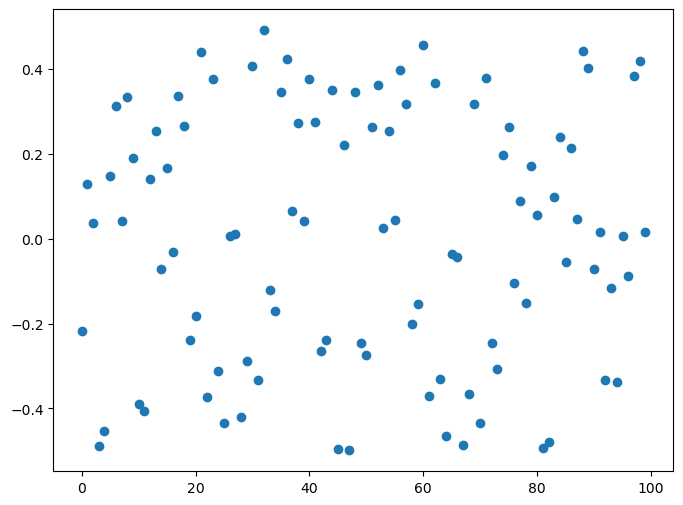

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(range(len(random_list_generator(100))), random_list_generator(100))
#plt.plot(range(len(random_list_generator(100))), random_list_generator(100))
plt.show()

## Пример перцептрона с несколькими скрытыми слоями

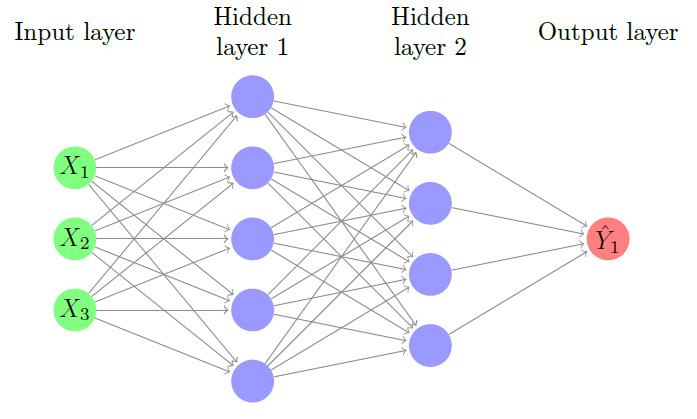

Рассмотрим пример нейронной сети, у которой имеется 2 скрутых слоя с 5 и 4 нейронами. На вход подаётся матрица $X$ с тремя признаками $X_1$,  $X_2$, $X_3$, каждый из которых соответствует столбцу матрица. На выход - один нейрон, соответствующий количеству стобцов в $Y$: в данном случае - один. 

$$X=\begin{pmatrix}\overbrace{x_{11}}^{X_1}&\overbrace{x_{12}}^{X_2}&\overbrace{x_{13}}^{X_3}\\x_{21}&x_{22}&x_{23}\\x_{31}&x_{32}&x_{33}\\x_{41}&x_{42}&x_{43}\end{pmatrix},\;\;\;\;Y=\begin{pmatrix}\begin{array}{c}y_1\\y_2\\y_3\\y_4\end{array}\end{pmatrix} $$

## Определение размерности матриц весов

Для нашего случая необходимо инициализировать три матрицы весов: $W_1$, $W_2$, $W_3$, каждая из которых относится к связям между слоями. Поскольку 
входных нейронов - 3, а на первом скрытом - 5, то размерность $W_1$ - (3x5);

на первом скрытом - 5, на втором скрытом - 4, то размерность $W_2$ - (5x4); 

на втором скрытом -4, на выходном слое - 1, то размерность $W_3$ - (4x1).

Т.е. можно определить следующие списки:

1) Для числа строк матриц весов: $[3,\;5,\;4]\Leftrightarrow\lbrack\overbrace{X.shape\lbrack1\rbrack}^{n_{in}},\;n_1\;n_2\rbrack$

2) Для числа столбцов матриц весов: $[5,\;4,\;1]\Leftrightarrow\lbrack n_1\;n_2,\;\overbrace{Y.shape\lbrack1\rbrack}^{n_{out}}\rbrack$

При этом длина списка на единицу больше числа скрытых слоёв и в данном случае $n_{layers}=n_{hidden}+1$. 

## Запрограммируем входные параметры и базу индукции

Зададим матрицу $X$ и вектор-столбец $Y$:

In [7]:
X = [[12, 5, -4], [3, 3, -2], [5, 0, 1], [17, -10, 4]]
Y = [[1], [4], [5], [-2]] #без ограничения общности Y - матрица с одним столбцом

Для дальнейшей работы с $X$ и $Y$ необходимо провести их нормировку:

In [8]:
def norm_matrix(matrix):

    matrix_transpose = list(zip(*matrix))
    
    matrix_empty = []
    for m in range(len(matrix_transpose)):
        normed_row = [abs(list(zip(*X))[m][x])/max(list(zip(*X))[m]) for x in range(len(list(zip(*X))[m]))]
        matrix_empty.append(normed_row)
     
    normed_matrix = list(zip(*matrix_empty))
    
    return normed_matrix
        


In [9]:
X = norm_matrix(X)
X

[(0.7058823529411765, 1.0, 1.0),
 (0.17647058823529413, 0.6, 0.5),
 (0.29411764705882354, 0.0, 0.25),
 (1.0, 2.0, 1.0)]

In [10]:
Y = norm_matrix(Y)
Y

[(0.7058823529411765,), (0.17647058823529413,), (0.29411764705882354,), (1.0,)]

Переменная $n_{hidden}$ - список числа нейронов на скрытых слоях. Соответсвенно, длина списка - число скрытых слоёв.

In [11]:
n_hidden = [5, 4]

### Начальные веса

Задаим список списков размерностей матриц весов:

In [12]:
w_rows_list = [len(X[0])] + n_hidden
w_cols_list = n_hidden +[len(Y[0])]
w_dim_list = list(zip(w_rows_list, w_cols_list))
w_dim_list

[(3, 5), (5, 4), (4, 1)]

In [13]:
initial_weights_matrix_list = []
for i in range(len(w_dim_list)):
    W_i = random_matrix_generator(w_dim_list[i][0], w_dim_list[i][1])
    initial_weights_matrix_list.append(W_i)

In [14]:
initial_weights_matrix_list[1]

[[0.2729436925340565,
  0.09177477013622592,
  0.4564932328064515,
  0.3670990805449037],
 [-0.1764076866486448,
  -0.17402706877419405,
  0.37424093416939286,
  0.4683963221796148],
 [0.10843909525829076,
  0.29436925340542075,
  0.026186796621914255,
  0.3038917249032238],
 [0.12748403825389687,
  0.49696373667757143,
  0.41233082016333356,
  -0.1264147112815408],
 [-0.11927285765705165,
  0.43375638103316305,
  -0.46732699520362075,
  0.177477013621683]]

Обернём в функцию генерацию начальных весов:

In [15]:
def initial_weights_matrix_generator(n_hidden):
    w_rows_list = [len(X[0])] + n_hidden
    w_cols_list = n_hidden +[len(Y[0])]
    w_dim_list = list(zip(w_rows_list, w_cols_list))
    initial_weights_matrix_list = []
    for i in range(len(w_dim_list)):
        W_i = random_matrix_generator(w_dim_list[i][0], w_dim_list[i][1])
        initial_weights_matrix_list.append(W_i)
    return initial_weights_matrix_list

In [16]:
initial_weights_matrix_generator(n_hidden)

[[[0.33384271731542015,
   0.3353708692616806,
   0.004584455838767099,
   0.34148347704672233,
   0.3460679328854894],
  [0.018337823355068394,
   0.3582931484556866,
   0.3659339081868893,
   0.04126010254913126,
   0.3842717315419577],
  [0.39496879516445915,
   0.07335129342027358,
   0.419419226305763,
   0.4331725938227464,
   0.11461139596940484]],
 [[0.33384271731542015,
   0.3353708692616806,
   0.004584455838767099,
   0.34148347704672233],
  [0.3460679328854894,
   0.018337823355068394,
   0.3582931484556866,
   0.3659339081868893],
  [0.04126010254913126,
   0.3842717315419577,
   0.39496879516445915,
   0.07335129342027358],
  [0.419419226305763,
   0.4331725938227464,
   0.11461139596940484,
   0.46373563274755725],
  [0.48054530415902263,
   0.16504041019652504,
   -0.48277904913265957,
   -0.4629130738321692]],
 [[0.33384271731542015],
  [0.3353708692616806],
  [0.004584455838767099],
  [0.34148347704672233]]]

### Функция активации

Будем использовать сигмоиду:

In [17]:
from math import exp
def sigmoid(z):
    return 1/(1+exp(-z))

## Прямое распространение ошибки (Forward Propagation)

Рассмотрим первый скрытый слой. Запишем первую формулу в матричном виде для прямого распространения ошибки, помня о размерностях множителей нашего рассматриваемого примера:
$$\underbrace{z^{(2)}}_{\left(4\times5\right)}=\underbrace X_{\left(4\times3\right)}\underbrace{W^{(1)}}_{\left(3\times5\right)}$$

Итак, размерность $z^{(2)}$ $(4\times 5)$. Подействуем на $z^{(2)}$ активационной функцией:
$$
a^{(2)} = f(z^{(2)}) 
$$
При этом размерность $a^{(2)}$ будет такой же, как у $z^{(2)}$.

Для второго скрытого слоя:
$$
\underbrace{z^{(3)}}_{\left(4\times4\right)}=\underbrace{a^{(2)}}_{\left(4\times5\right)}\underbrace{W^{(2)}}_{\left(5\times4\right)}
$$
$$
a^{(3)} = f(z^{(3)}) 
$$

И, наконец, для выходного слоя:
$$
\underbrace{z^{(4)}}_{\left(4\times1\right)}=\underbrace{a^{(3)}}_{\left(4\times4\right)}\underbrace{W^{(3)}}_{\left(4\times1\right)}\\
$$
И предсказанное значение $\hat{y}$:
$$
\widehat y=f(z^{(4)})\\
$$

Т.е. нужно запрограммировать цикл на количество итераций $n_{layers}=n_{hidden}+1$, у которого базой индукции является $z^{(2)}$. Далее последовательно искать $a^{(2)}$, $z^{(3)}$ и т.д. до $\hat{y}$.

### Функция для перемножения матриц

Без такой функции вычисление нейронной сети просто невозможно.

In [18]:
a = [[1,2,3,4], [1,2,3,1]]
b = [[2],[3],[4],[5]]

In [19]:
def matrix_multiple(a,b):
    zip_b = zip(*b)
    # uncomment next line if python 3 : 
    zip_b = list(zip_b)
    return [[sum(ele_a*ele_b for ele_a, ele_b in zip(row_a, col_b)) 
             for col_b in zip_b] for row_a in a]

x = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
y = [[1,2],[1,2],[3,4]]

In [20]:
matrix_multiple(a,b)

[[40], [25]]

## Вычисление $a^{(i)}$, $z^{(i)}$

Задаём базу индукции:

In [21]:
z_initial = matrix_multiple(X, initial_weights_matrix_list[0])
a_initial =  [*zip(*[[sigmoid(z_initial[i][j]) for i in range(len(z_initial))] for j in range(len(z_initial[0]))])]

Производим цикл:

In [22]:
z_list = []
z_list.append(z_initial)

a_list = []
a_list.append(a_initial)

for g in range(len(n_hidden)):
    z_g = matrix_multiple(a_list[g], initial_weights_matrix_list[g+1])
    z_list.append(z_g)
    a_g = [*zip(*[[sigmoid(z_list[g+1][a][b]) for a in range(len(z_list[g+1]))] for b in range(len(z_list[g+1][0]))])]
    a_list.append(a_g)
    

Обернём в функции создание списков $a^{(i)}$ и $z^{(i)}$:

In [23]:
def z_a_list_func(weights):
    z_initial = matrix_multiple(X, weights[0])
    a_initial =  [*zip(*[[sigmoid(z_initial[i][j]) for i in range(len(z_initial))] for j in range(len(z_initial[0]))])]

    z_list = []
    z_list.append(z_initial)

    a_list = []
    a_list.append(a_initial)

    for g in range(len(n_hidden)):
        z_g = matrix_multiple(a_list[g], weights[g+1])
        z_list.append(z_g)
        a_g = [*zip(*[[sigmoid(z_list[g+1][a][b]) for a in range(len(z_list[g+1]))] for b in range(len(z_list[g+1][0]))])]
        a_list.append(a_g)
    return z_list, a_list
    
    

In [24]:
z_a_list_func(initial_weights_matrix_list)[0][2]
    

[[0.7395065486759126],
 [0.7238412302636227],
 [0.7206444417405538],
 [0.7467871532090113]]

# Обратное распространение ошибки (Backward Propagation)

Итак, у нас есть уравнения для прямого распространения ошибки:
$$
z^{(2)} = XW^{(1)} \tag{1}\\
$$
$$
a^{(2)} = f(z^{(2)}) \tag{2}\\
$$
$$
z^{(3)} = a^{(2)}W^{(2)} \tag{3}\\
$$
$$
a^{(3)} = f(z^{(3)}) \tag{4}\\
$$
$$
z^{(4)} = a^{(3)}W^{(3)} \tag{5}\\
$$
$$
\hat{y} = f(z^{(4)}) \tag{6}\\
$$

И уравнение для среднеквадратичной ошибки, по которой будем оптимизировать веса $W^{(i)}$:
$$
E = \sum \frac{1}{2}(y-\hat{y})^2 \tag{7}\\
$$

Для оптимизации весов необходимо минимизировать среднеквадричную ошибку, для чего будем скать производные:

$$
\frac{\partial E}{\partial W^{(3)}}=\frac{\partial\sum\frac12(y-\widehat y)^2}{\partial W^{(3)}}=\frac{\partial\frac12(y-\widehat y)^2}{\partial\widehat y}\frac{\partial\widehat y}{\partial W^{(3)}}=(y-\widehat y{)\frac{\partial\widehat y}{\partial z^{(4)}}\frac{\partial z^{(4)}}{\partial W^{(3)}}}=\underset{\delta^{\left(3\right)}}{\underbrace{(y-\widehat y{)f'\left(z^{(4)}\right)}}a^{\left(3\right)}\;}=\delta^{\left(3\right)}a^{\left(3\right)},
$$

$$
\frac{\partial E}{\partial W^{(2)}}=\frac{\partial\sum\frac12(y-\widehat y)^2}{\partial W^{(2)}}=\frac{\partial\frac12(y-\widehat y)^2}{\partial\widehat y}\frac{\partial\widehat y}{\partial W^{(2)}}=(y-\widehat y{)\frac{\partial\widehat y}{\partial z^{(4)}}\frac{\partial z^{(4)}}{\partial W^{(2)}}}=
\underbrace{(y-\widehat y)f'\left(z^{(4)}\right)}_{\delta^{\left(3\right)}}\frac{\partial z^{(4)}}{\partial a^{(3)}}\frac{\partial a^{(3)}}{\partial W^{(2)}}=\delta^{\left(3\right)}W^{(3)}\frac{\partial a^{(3)}}{\partial z^{(3)}}\frac{\partial z^{(3)}}{\partial W^{(2)}}=\\=\underbrace{\delta^{\left(3\right)}W^{(3)}f'\left(z^{(3)}\right)}_{\delta^{\left(2\right)}}a^{\left(2\right)}=\delta^{\left(2\right)}a^{\left(2\right)}
$$

$$
\frac{\partial E}{\partial W^{(1)}}=\frac{\partial\sum\frac12(y-\widehat y)^2}{\partial W^{(1)}}=\frac{\partial\frac12(y-\widehat y)^2}{\partial\widehat y}\frac{\partial\widehat y}{\partial W^{(1)}}=(y-\widehat y{)\frac{\partial\widehat y}{\partial z^{(4)}}\frac{\partial z^{(4)}}{\partial W^{(1)}}=}\\=\delta^{\left(3\right)}\frac{\partial z^{(4)}}{\partial a^{(3)}}\frac{\partial a^{(3)}}{\partial W^{(1)}}=\delta^{\left(3\right)}W^{(3)}\frac{\partial a^{(3)}}{\partial z^{(3)}}\frac{\partial z^{(3)}}{\partial W^{(1)}}=\delta^{\left(3\right)}W^{(3)}f'\left(z^{\left(3\right)}\right)\frac{\partial z^{(3)}}{\partial a^{(2)}}\frac{\partial a^{(2)}}{\partial W^{(1)}}=\\=\underbrace{\delta^{\left(3\right)}W^{(3)}f'\left(z^{\left(3\right)}\right)}_{\delta^{\left(2\right)}}W^{(2)}\frac{\partial a^{(2)}}{\partial z^{(2)}}\frac{\partial z^{(2)}}{\partial W^{(1)}}=\underbrace{\delta^{\left(2\right)}W^{(2)}f'\left(z^{\left(2\right)}\right)}_{\delta^{\left(1\right)}}X=\delta^{\left(1\right)}X
$$

Таким образом, можно проследить рекуррентные соотношения:

$$
a^{\left(i\right)}=f\left(z^{\left(i\right)}\right)\\\frac{\partial E}{\partial W^{(i)}}=\left(a^{\left(i\right)}\right)^T\delta^{\left(i\right)}\\\delta^{\left(i\right)}=\left(y-\widehat y\right)f'\left(z^{\left(i+1\right)}\right)\\\delta^{\left(i-1\right)}=\delta^{\left(i\right)}\left(W^{\left(i\right)}\right)^Tf'\left(z^{\left(i\right)}\right)
$$

Для решения данной задача понадобится создать функцию для производной от сигмоиды:
$$
f'(z)=\frac{\partial{}}{\partial z}\left(\frac1{1+e^{-z}}\right)=\frac{e^{-z}}{(1+e^{-z})^2}
$$

In [25]:
def sigmoid_prime(z):
    from math import exp
    return exp(-z)/((1+exp(-z))**2)

In [26]:
prime_list = []
for p in range(len(n_hidden)+1):
    prime_list_p = [*zip(*[[sigmoid_prime(z_list[p][i][j]) for i in range(len(z_list[p]))] for j in range(len(z_list[p][0]))])]
    prime_list.append(prime_list_p)

In [27]:
prime_list[2]

[(0.21871065576368015,),
 (0.21991429245604563,),
 (0.22015781349125482,),
 (0.21814552023573053,)]

Обернём в функцию выражение для списка производных:

In [28]:
def prime(z_list_):
    prime_list = []
    for p in range(len(n_hidden)+1):
        prime_list_p = [*zip(*[[sigmoid_prime(z_list_[p][i][j]) for i in range(len(z_list_[p]))] for j in range(len(z_list_[p][0]))])]
        prime_list.append(prime_list_p)
    return prime_list

In [29]:
prime(z_list)

[[(0.24987445716669776,
   0.2184465441334084,
   0.20392236046203166,
   0.2085443670861797,
   0.2299584503644234),
  (0.24988363193584626,
   0.24060474482737623,
   0.23902539588759997,
   0.24126342323426264,
   0.24242766859082354),
  (0.24952943811734973,
   0.24933855055507692,
   0.24828287840895302,
   0.24665992854054894,
   0.2498362437608662),
  (0.24985046444562503,
   0.18320852391401954,
   0.14718240611520794,
   0.18915291503894577,
   0.21188720718504117)],
 [(0.2492361504970763,
   0.2165331521246676,
   0.23523485192576069,
   0.218116541329866),
  (0.24938291494076395,
   0.22401831422859875,
   0.23864216192566048,
   0.22376253660491485),
  (0.24912717990159527,
   0.2277475808244598,
   0.23830964732037635,
   0.22724325911040202),
  (0.24936857458731518,
   0.21169543409655145,
   0.2343663871741772,
   0.21287293705748844)],
 [(0.21871065576368015,),
  (0.21991429245604563,),
  (0.22015781349125482,),
  (0.21814552023573053,)]]

Посчитаем ошибки $\delta^{(i)}$, возникающие прии вычислении каждой производной $\frac{\partial E}{\partial W^{(i)}}$:

In [30]:
a_list[-1]

[(0.6768879425973399,),
 (0.6734523206646553,),
 (0.6727489117440256,),
 (0.6784782333066681,)]

In [31]:
Y

[(0.7058823529411765,), (0.17647058823529413,), (0.29411764705882354,), (1.0,)]

In [32]:
discrepansy = []
for yy in range(len(Y)):
    dis_i = Y[yy][0] - a_list[-1][yy][0]
    discrepansy.append(dis_i)
discrepansy = [discrepansy[i:i+len(Y[0])] for i in range(0,len(Y), len(Y[0]))]

In [33]:
discrepansy

[[0.028994410343836652],
 [-0.49698173242936117],
 [-0.3786312646852021],
 [0.3215217666933319]]

Обернём в функцию выражение для невязки:

In [34]:
def discrepansy(a_list_):
    discrepansy_list = []
    for yy in range(len(Y)):
        dis_i = Y[yy][0] - a_list_[-1][yy][0]
        discrepansy_list.append(dis_i)
    discrepansy_list = [discrepansy_list[i:i+len(Y[0])] for i in range(0,len(Y), len(Y[0]))]
    return discrepansy_list

In [35]:
disc = discrepansy(a_list)
disc 

[[0.028994410343836652],
 [-0.49698173242936117],
 [-0.3786312646852021],
 [0.3215217666933319]]

Подсчитаем последнюю $\delta$ как базу индукции для вычислния предыдущих $\delta$:

In [36]:
delta_last = [[disc[q][0]*prime_list[-1][q][0] for q in range(len(Y))][i:i+len(Y[0])] for i in range(0,len(Y), len(Y[0]))] 
delta_last

[[0.006341386499781745],
 [-0.10929338605078275],
 [-0.08335863135252265],
 [0.07013853306242807]]

In [37]:
delta_list = []
delta_list.append(delta_last)

In [38]:
[*zip(*initial_weights_matrix_list[-1])]

[(0.2729436925340565,
  0.09177477013622592,
  0.4564932328064515,
  0.3670990805449037)]

In [39]:
prime_list[-1]

[(0.21871065576368015,),
 (0.21991429245604563,),
 (0.22015781349125482,),
 (0.21814552023573053,)]

In [40]:
matrix_multiple([*zip(*initial_weights_matrix_list[-1])], prime_list[-1])

[[0.2604598495322572]]

In [41]:
delta_list = []
delta_list.append(delta_last)
for d in range(len(n_hidden)):
    delta_i = matrix_multiple(delta_list[0], matrix_multiple([*zip(*initial_weights_matrix_list[-d-1])], prime_list[-d-2]))
    delta_list.insert(0, delta_i)

In [42]:
delta_list[2]

[[0.006341386499781745],
 [-0.10929338605078275],
 [-0.08335863135252265],
 [0.07013853306242807]]

Обернём в функцию выражение для $\delta$:

In [43]:
def delta(weights, discrepansy_, prime_):
    delta_last = [[discrepansy_[q][0]*prime_[-1][q][0] for q in range(len(Y))][i:i+len(Y[0])] for i in range(0,len(Y), len(Y[0]))] 
    delta_list = []
    delta_list.append(delta_last)
    for d in range(len(n_hidden)):
        delta_i = matrix_multiple(delta_list[0], matrix_multiple([*zip(*weights[-d-1])], prime_[-d-2]))
        delta_list.insert(0, delta_i)
    return delta_list
    

In [44]:
delta(initial_weights_matrix_list, disc, prime_list)

[[[0.0014346637244600064,
   0.0012553556985175711,
   0.001165222094549323,
   0.0012413335554740008,
   0.0013270429381256334],
  [-0.024726336471662457,
   -0.021635974245356772,
   -0.020082527412398528,
   -0.021394303517200872,
   -0.02287149918200407],
  [-0.018858904835120028,
   -0.016501869566319036,
   -0.015317047624631356,
   -0.01631754605082577,
   -0.01744421083180949],
  [0.015868013891751846,
   0.013884787998431031,
   0.012887870563705935,
   0.013729696908572151,
   0.01467768050318174]],
 [[0.00187820669935869,
   0.0016572517081720557,
   0.0017814833326914691,
   0.0016611246653869577],
  [-0.032370770947842534,
   -0.028562625970014847,
   -0.030703749981109814,
   -0.02862937613704236],
  [-0.024689354585321042,
   -0.02178486269597469,
   -0.023417909063830556,
   -0.021835773393932025],
  [0.020773794924119095,
   0.01832993521691064,
   0.0197039918059632,
   0.018372771832795214]],
 [[0.006341386499781745],
  [-0.10929338605078275],
  [-0.08335863135252265

Считаем производные $\frac{\partial E}{\partial W^{(i)}}$:

In [45]:
dEdW_list_initial = []
corr_list = [X]+a_list[0:len(a_list)-1]
for e in range(len(n_hidden)+1):
    dEdW_e = matrix_multiple([*zip(*corr_list[e])], delta_list[e])
    dEdW_list_initial.append(dEdW_e)                      

Обернём в функцию:

In [46]:
def dEdW(a_list, delta_):
    dEdW_list = []
    corr_list = [X]+a_list[0:len(a_list)-1]
    for e in range(len(n_hidden)+1):
        dEdW_e = matrix_multiple([*zip(*corr_list[e])], delta_[e])
        dEdW_list.append(dEdW_e)
    return dEdW_list
        

In [47]:
dEdW(a_list, delta_list)

[[[0.006970509838983173,
   0.006099317281639581,
   0.005661390844543554,
   0.006031188782687241,
   0.006447619535678677],
  [0.018334889624966225,
   0.01604334714816557,
   0.014891446774522078,
   0.01586414526229778,
   0.016959504435286668],
  [0.00022478317160061836,
   0.00019668918269045814,
   0.0001825670458981566,
   0.00019449219273927343,
   0.00020792114235296429]],
 [[-0.017623424961805963,
   -0.01555017939812879,
   -0.016715858720510453,
   -0.015586519791803468],
  [-0.015274288889998752,
   -0.013477399139672473,
   -0.014487697805325878,
   -0.013508895495946369],
  [-0.014553971671399234,
   -0.012841821095276509,
   -0.013804475282680275,
   -0.012871832121011575],
  [-0.01614989820476978,
   -0.014250000490253927,
   -0.015318215234928599,
   -0.014283302397223726],
  [-0.016015423674980822,
   -0.014131345741405203,
   -0.01519066583710548,
   -0.014164370355092779]],
 [[-0.06132601976154584],
  [-0.07325039157944932],
  [-0.06920639997038347],
  [-0.0737174

## Обновление весов

Веса обновляют с помощью следующих формул:
$$
W^{\left(3\right)}\leftarrow W^{\left(3\right)}-\eta\frac{\partial E}{\partial W^{\left(3\right)}}\\W^{\left(2\right)}\leftarrow W^{\left(2\right)}-\eta\frac{\partial E}{\partial W^{\left(2\right)}}\\W^{\left(1\right)}\leftarrow W^{\left(1\right)}-\eta\frac{\partial E}{\partial W^{\left(1\right)}},
$$
где $\eta$ - шаг обучения.

Рекуррентно соотношения можно записать в следующем виде:
$$
W^{\left(i\right)}\leftarrow W^{\left(i\right)}-\eta\frac{\partial E}{\partial W^{\left(i\right)}},
$$
что должно повторяться для заданного количества эпох.

In [48]:
eta = 0.001
epochs = 1000

Функция для вычитания матриц:

In [49]:
def matrix_diff(matrix1, matrix2):
    
    empty_chain = [None]*len(matrix1)*len(matrix1[0])
    matrix_diff = [empty_chain[i:i+len(matrix1[0])] for i in range(0, len(empty_chain), len(matrix1[0]))]

    # Iterate through matrix rows
    for i in range(len(matrix1)):
    # Iterate through matrix columns
        for j in range(len(matrix1[0])):
    # Subtraction of matrix elements
            matrix_diff[i][j] = matrix1[i][j] - matrix2[i][j]
    return matrix_diff


x = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]
y = [[1,2,3],[4,5,6],[7,8,9],[10,11,112]]

matrix_diff(x,y)

[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, -100]]

Функция для умножения матрицы на число:

In [50]:
def num_matrix(n, matrix):
    return [list(map(lambda x: x*n, z)) for z in matrix]

In [51]:
num_matrix(0.001, dEdW_list_initial[0])

[[6.970509838983173e-06,
  6.0993172816395816e-06,
  5.661390844543554e-06,
  6.031188782687241e-06,
  6.447619535678677e-06],
 [1.8334889624966224e-05,
  1.604334714816557e-05,
  1.4891446774522077e-05,
  1.586414526229778e-05,
  1.6959504435286667e-05],
 [2.2478317160061838e-07,
  1.9668918269045813e-07,
  1.825670458981566e-07,
  1.9449219273927344e-07,
  2.0792114235296428e-07]]

Применим написанные выше функции для обновления матриц весов на 1-ой итерации:

In [52]:
w_updated_matrix = []
for n in range(len(n_hidden)+1):
    w_updated_n = matrix_diff(initial_weights_matrix_list[n], num_matrix(0.001, dEdW_list_initial[n]))
    w_updated_matrix.append(w_updated_n)

Обернём в функцию:

In [65]:
def weights_update(eta, weights, dEdW):
    w_updated_matrix = []
    for n in range(len(n_hidden)+1):
        w_updated_n = matrix_diff(weights[n], num_matrix(-eta, dEdW[n]))
        w_updated_matrix.append(w_updated_n)
    return  w_updated_matrix

In [54]:
weights_update(0.001, initial_weights_matrix_list, dEdW_list_initial)

[[[0.2729367220242175,
   0.09176867081894428,
   0.4564875714156069,
   0.367093049356121,
   -0.17641413426818048],
  [-0.17404540366381901,
   0.3742248908222447,
   0.4683814307328403,
   0.10842323111302847,
   0.29435229390098544],
  [0.026186571838742654,
   0.30389152821404114,
   0.12748385568685097,
   0.4969635421853787,
   0.4123306122421912]],
 [[0.2729613159590183,
   0.09179032031562405,
   0.45650994866517197,
   0.3671146670646955],
  [-0.1763924123597548,
   -0.17401359137505437,
   0.3742554218671982,
   0.46840983107511075],
  [0.10845364922996216,
   0.29438209522651604,
   0.026200601097196935,
   0.3039045967353448],
  [0.12750018815210165,
   0.4969779866780617,
   0.4123461383785685,
   -0.12640042797914358],
  [-0.11925684223337667,
   0.43377051237890446,
   -0.46731180453778365,
   0.1774911779920381]],
 [[0.27300501855381804],
  [0.09184802052780537],
  [0.45656243920642187],
  [0.367172797972004]]]

Теперь необходимо создать цикл для обновления весов в зависимости от числа эпох. Для этого соберём все вышенаписанные функции:

In [66]:
#пустые списки, котрые будут заполняться в цикле
w_list_total = []
a_list_total= []
z_list_total= []
prime_list_total = []
discrepansy_list_total = []
delta_list_total = []
dEdW_list_total = []

#База индукции
w_0 = initial_weights_matrix_generator(n_hidden)
z_0, a_0 = z_a_list_func(w_0)
p_0 = prime(z_0)
dis_0 = discrepansy(a_0)
del_0 = delta(w_0, dis_0, p_0)
dEdW_0 = dEdW(a_0, del_0)


w_list_total.append(w_0)
a_list_total.append(a_0)
z_list_total.append(z_0)
prime_list_total.append(p_0)
discrepansy_list_total.append(dis_0)
delta_list_total.append(del_0)
dEdW_list_total.append(dEdW_0)

for epoch in range(epochs):
    
    z_a_list_epoch = z_a_list_func(w_list_total[epoch])
    a_list_total.append(z_a_list_epoch[0])
    z_list_total.append(z_a_list_epoch[1])
    
    prime_epoch = prime(z_list_total[epoch])
    prime_list_total.append(prime_epoch)
    
    discrepansy_epoch = discrepansy(a_list_total[epoch])
    discrepansy_list_total.append(discrepansy_epoch)
    
    delta_epoch = delta(w_list_total[epoch], discrepansy_list_total[epoch], prime_list_total[epoch])
    delta_list_total.append(delta_epoch)
    
    dEdW_epoch = dEdW(a_list_total[epoch], delta_list_total[epoch])
    dEdW_list_total.append(dEdW_epoch)
    
    w_epoch = weights_update(-eta, w_list_total[epoch], dEdW_list_total[epoch])
    w_list_total.append(w_epoch)

Визуализируем полученный результат, пронаблюдав изменение СКО от эпохи:

In [67]:
discrepansy_list_total[0]

[[0.26093589754150165],
 [-0.26962629474254274],
 [-0.15231378760499376],
 [0.5557076815460639]]

In [68]:
loss_list = []
for loss in range(epochs):
    loss_epoch = 0.5*sum([(discrepansy_list_total[loss][i][0])**2 for i in range(len(discrepansy_list_total[loss]))])
    loss_list.append(loss_epoch)

In [83]:
len(loss_list[2:len(loss_list)])

998

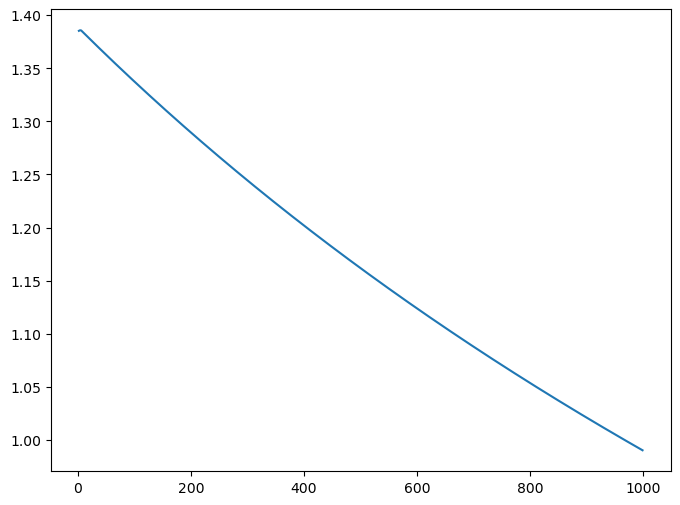

In [86]:
plt.figure(figsize=(8,6))
plt.plot(range(2, len(loss_list)), loss_list[2:len(loss_list)])
plt.show()

Хотелось бы отметить, что в данном блокноте дважды (один до обетывания в функцию, второй раз -после обёртывания) в начало массива потерь записалось число потерь для случайных начальных весов, которое можно выбросить из рассмотрения. Из графика видно, что СКО уменьшается вместе с новой эпохой, что и требовало доказать эффективность нейронных сетей.

# Собственный класс для нейронной сети

Теперь соберем все вышеприведенные функции под один класс. При этом еще создадим функциюб которая будем производить вычислительный цикл:

In [113]:
class Neural_Network(object):
    def __init__(self):#, n_hidden, eta, epochs): 
        pass 
        
    @staticmethod
    def norm_matrix(matrix):
        matrix_transpose = list(zip(*matrix))
        matrix_empty = []
        for m in range(len(matrix_transpose)):
            normed_row = [abs(list(zip(*X))[m][x])/max(list(zip(*X))[m]) for x in range(len(list(zip(*X))[m]))]
            matrix_empty.append(normed_row)
        normed_matrix = list(zip(*matrix_empty))
        return normed_matrix
    
    @staticmethod
    def random_number():
        import datetime    
        my_dt_ob = datetime.datetime.now()
        date_list = [my_dt_ob.year, my_dt_ob.month, my_dt_ob.day, my_dt_ob.hour, my_dt_ob.minute, my_dt_ob.second, my_dt_ob.microsecond]     
        dt_random_num = date_list[6]**(1/(date_list[5]+0.0001))*date_list[4]
        return dt_random_num  
    
    @staticmethod
    def random_list_generator(list_len):
        my_random_list = []
        for i in range(list_len):
            my_random_list_i = (i+1)*(Neural_Network.random_number()*(i+1)-i*2)
            my_random_list.append(my_random_list_i-round(my_random_list_i))
        return my_random_list
   
    @staticmethod
    def random_matrix_generator(rows_len, cols_len):
        my_random_chain = Neural_Network.random_list_generator(rows_len * cols_len)   
        nev = [my_random_chain[i:i+cols_len] for i in range(0,len(my_random_chain), cols_len)]
        return nev
    
    @staticmethod
    def sigmoid_prime(z):
        from math import exp
        return exp(-z)/((1+exp(-z))**2)
    
    @staticmethod
    def sigmoid(z):
        from math import exp
        return 1/(1+exp(-z))

    @staticmethod
    def matrix_multiple(a,b):
        zip_b = zip(*b)
        zip_b = list(zip_b)
        return [[sum(ele_a*ele_b for ele_a, ele_b in zip(row_a, col_b)) 
                 for col_b in zip_b] for row_a in a]
    
    @staticmethod
    def matrix_diff(matrix1, matrix2):   
        empty_chain = [None]*len(matrix1)*len(matrix1[0])
        matrix_diff = [empty_chain[i:i+len(matrix1[0])] for i in range(0, len(empty_chain), len(matrix1[0]))]
        for i in range(len(matrix1)):
            for j in range(len(matrix1[0])):
                matrix_diff[i][j] = matrix1[i][j] - matrix2[i][j]
        return matrix_diff
    
    @staticmethod
    def num_matrix(n, matrix):
        return [list(map(lambda x: x*n, z)) for z in matrix]
    
    @staticmethod
    def initial_weights_matrix_generator( X, n_hidden):
        w_rows_list = [len(X[0])] + n_hidden
        w_cols_list = n_hidden +[len(Y[0])]
        w_dim_list = list(zip(w_rows_list, w_cols_list))
        initial_weights_matrix_list = []
        for i in range(len(w_dim_list)):
            W_i = Neural_Network.random_matrix_generator(w_dim_list[i][0], w_dim_list[i][1])
            initial_weights_matrix_list.append(W_i)
        return initial_weights_matrix_list
      
    @staticmethod
    def z_a_list_func(X, n_hidden, weights):
        z_initial = Neural_Network.matrix_multiple(X, weights[0])
        a_initial =  [*zip(*[[Neural_Network.sigmoid(z_initial[i][j]) for i in range(len(z_initial))] for j in range(len(z_initial[0]))])]

        z_list = []
        z_list.append(z_initial)

        a_list = []
        a_list.append(a_initial)

        for g in range(len(n_hidden)):
            z_g = Neural_Network.matrix_multiple(a_list[g], weights[g+1])
            z_list.append(z_g)
            a_g = [*zip(*[[Neural_Network.sigmoid(z_list[g+1][a][b]) for a in range(len(z_list[g+1]))] for b in range(len(z_list[g+1][0]))])]
            a_list.append(a_g)
        return z_list, a_list
    
    @staticmethod    
    def prime(n_hidden, z_list_):
        prime_list = []
        for p in range(len(n_hidden)+1):
            prime_list_p = [*zip(*[[Neural_Network.sigmoid_prime(z_list_[p][i][j]) for i in range(len(z_list_[p]))] for j in range(len(z_list_[p][0]))])]
            prime_list.append(prime_list_p)
        return prime_list
    
    @staticmethod    
    def discrepansy(Y, a_list_):
        discrepansy_list = []
        for yy in range(len(Y)):
            dis_i = Y[yy][0] - a_list_[-1][yy][0]
            discrepansy_list.append(dis_i)
        discrepansy_list = [discrepansy_list[i:i+len(Y[0])] for i in range(0,len(Y), len(Y[0]))]
        return discrepansy_list
    
    @staticmethod    
    def delta(Y, weights, discrepansy_, prime_):
        delta_last = [[discrepansy_[q][0]*prime_[-1][q][0] for q in range(len(Y))][i:i+len(Y[0])] for i in range(0,len(Y), len(Y[0]))] 
        delta_list = []
        delta_list.append(delta_last)
        for d in range(len(n_hidden)):
            delta_i = Neural_Network.matrix_multiple(delta_list[0], Neural_Network.matrix_multiple([*zip(*weights[-d-1])], prime_[-d-2]))
            delta_list.insert(0, delta_i)
        return delta_list
    
    @staticmethod    
    def dEdW( X, n_hidden, a_list_, delta_):
        dEdW_list = []
        corr_list = [X]+a_list_[0:len(a_list_)-1]
        for e in range(len(n_hidden)+1):
            dEdW_e = Neural_Network.matrix_multiple([*zip(*corr_list[e])], delta_[e])
            dEdW_list.append(dEdW_e)
        return dEdW_list
    
    @staticmethod    
    def weights_update(eta, weights, dEdW):
        w_updated_matrix = []
        for n in range(len(n_hidden)+1):
            w_updated_n = Neural_Network.matrix_diff(weights[n], Neural_Network.num_matrix(-eta, dEdW[n]))
            w_updated_matrix.append(w_updated_n)
        return  w_updated_matrix
    
    @staticmethod
    def calculus(X, Y, n_hidden, epochs, eta):
        
        X_normed = Neural_Network.norm_matrix(X)
        Y_normed = Neural_Network.norm_matrix(Y)
        
        w_list_total = []
        a_list_total= []
        z_list_total= []
        prime_list_total = []
        discrepansy_list_total = []
        delta_list_total = []
        dEdW_list_total = []

        #База индукции
        w_0 = Neural_Network.initial_weights_matrix_generator(X_normed, n_hidden)
        z_0, a_0 = Neural_Network.z_a_list_func(X_normed, n_hidden, w_0)
        p_0 = Neural_Network.prime(n_hidden, z_0)
        dis_0 = Neural_Network.discrepansy(Y_normed, a_0)
        del_0 = Neural_Network.delta(Y_normed, w_0, dis_0, p_0)
        dEdW_0 = Neural_Network.dEdW(X_normed, n_hidden, a_0, del_0)


        w_list_total.append(w_0)
        a_list_total.append(a_0)
        z_list_total.append(z_0)
        prime_list_total.append(p_0)
        discrepansy_list_total.append(dis_0)
        delta_list_total.append(del_0)
        dEdW_list_total.append(dEdW_0)

        for epoch in range(epochs):

            z_a_list_epoch = Neural_Network.z_a_list_func(X, n_hidden, w_list_total[epoch])
            a_list_total.append(z_a_list_epoch[0])
            z_list_total.append(z_a_list_epoch[1])

            prime_epoch = Neural_Network.prime(n_hidden, z_list_total[epoch])
            prime_list_total.append(prime_epoch)

            discrepansy_epoch = Neural_Network.discrepansy(Y_normed, a_list_total[epoch])
            discrepansy_list_total.append(discrepansy_epoch)

            delta_epoch = Neural_Network.delta(Y_normed, w_list_total[epoch], discrepansy_list_total[epoch], prime_list_total[epoch])
            delta_list_total.append(delta_epoch)

            dEdW_epoch = Neural_Network.dEdW(X_normed, n_hidden, a_list_total[epoch], delta_list_total[epoch])
            dEdW_list_total.append(dEdW_epoch)

            w_epoch = Neural_Network.weights_update(-eta, w_list_total[epoch], dEdW_list_total[epoch])
            w_list_total.append(w_epoch)

        return a_list_total, z_list_total, prime_list_total, discrepansy_list_total, delta_list_total, dEdW_list_total, w_list_total
    

In [120]:
Neural_Network()

In [137]:
X = [[12, 5, -4], [3, 3, -2], [5, 0, 1], [17, -10, 4]]
Y = [[1], [4], [5], [-2]]
n_hidden = [1,2]
epochs = 2000
eta = 0.01

In [138]:
NN1 = Neural_Network.calculus(X, Y, n_hidden, epochs, eta)

In [139]:
loss_list = []
for loss in range(epochs):
    loss_epoch = 0.5*sum([(NN1[3][loss][i][0])**2 for i in range(len(NN1[3][loss]))])
    loss_list.append(loss_epoch)

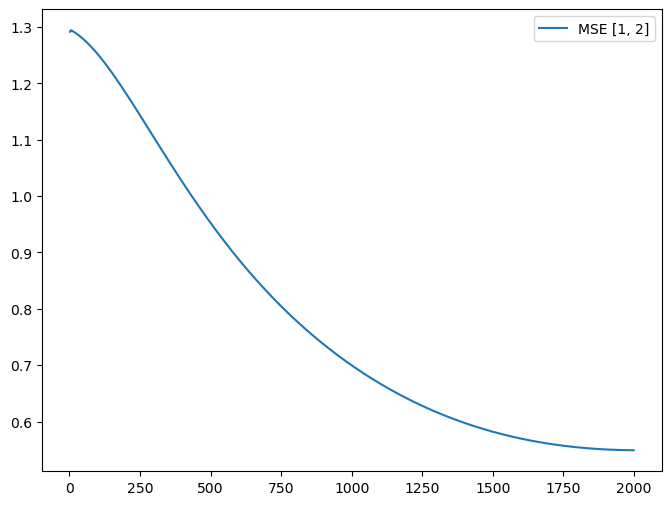

In [140]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(range(2, len(loss_list)), loss_list[2:len(loss_list)], label=f'MSE {n_hidden}')
plt.legend()
plt.show()

In [125]:
n_hidden_list = [
    [2, 3, 4],
    [2, 2],
    [1, 5, 2],
    [3, 4, 5, 3],
    [2, 1, 3, 5, 2]
]

In [108]:
def MSE(NN_discrepansy):
    loss_list = []
    for loss in range(len(NN_discrepansy)):
        loss_epoch = 0.5*sum([(NN_discrepansy[loss][i][0])**2 for i in range(len(NN_discrepansy[loss]))])
        loss_list.append(loss_epoch)
    return loss_list

In [109]:
loss_new_MSE = MSE(NN_discrepansy)

In [110]:
len(loss_new_MSE[2:len(loss_new_MSE)])

999

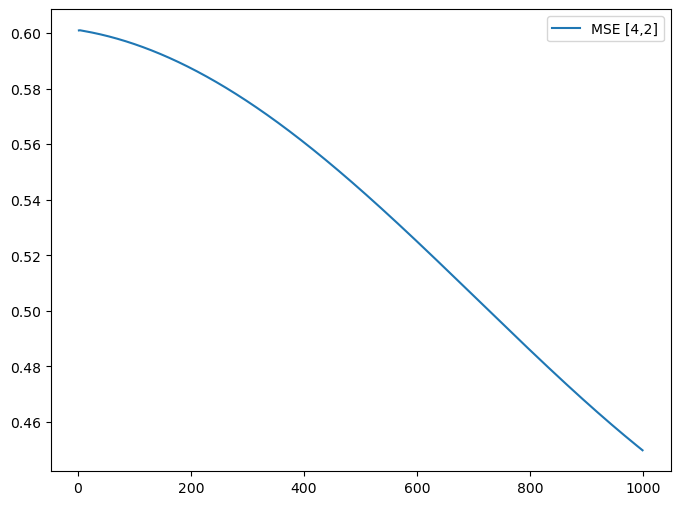

In [111]:
plt.figure(figsize=(8,6))
plt.plot(range(2, len(loss_new_MSE)-1), loss_list[2:len(loss_new_MSE)], label=f'MSE [4,2]')
#plt.plot(range(2, len(loss_list)), loss_list[2:len(loss_list)], label=f'MSE {n_hidden}')
plt.legend()
plt.show()